# Connecting to google drive
Felix Zaussinger | 11.11.2020

## Core Analysis Goal(s)
1. Auto-connect to our google sheets documents
    - https://docs.google.com/spreadsheets/d/1kEEcKdP__1XbYKe5-nVlxzAD_P5-EQx-23IAw9SXOoc/edit#gid=370671396

2. Based on
    - https://towardsdatascience.com/how-to-access-google-sheet-data-using-the-python-api-and-convert-to-pandas-dataframe-5ec020564f0e
    - https://developers.google.com/sheets/api/quickstart/python.

## Key Insight(s)
1. It works.

In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import os
import os.path
import numpy as np
import pandas as pd
import seaborn as sns
import configparser
from src.gecm import io
from pathlib import Path

sns.set_theme(
    context='talk', style='ticks', palette='Paired', font='sans-serif',
    font_scale=1.05, color_codes=True, rc=None
)

#### Define paths

In [2]:
abspath = os.path.abspath('')
project_dir = str(Path(abspath).parents[0])

data_raw = os.path.join(project_dir, "data", "raw")
data_processed = os.path.join(project_dir, "data", "processed")

#### Authentification

In [3]:
# init config file parser. methods: config.getboolean, config.getint, ... .
config = configparser.ConfigParser()
fpath_cf = os.path.join(project_dir, 'config.ini')
config.read(fpath_cf)

# read sections
io.config_describe(config)


--- default ---
credentials: 'google_api_credentials.json'
scopes: https://www.googleapis.com/auth/spreadsheets.readonly

--- gdrive_spreadsheet_ids ---
spreadsheet_id_farmers: 1kEEcKdP__1XbYKe5-nVlxzAD_P5-EQx-23IAw9SXOoc
spreadsheet_id_foresters: 1ir8WkfKpyEGkamASbd0pf9IDAE74M4Q1fsHYl4r9F34
spreadsheet_id_tourism: 1EA_mCM9Pp_URb_JavM-mMIqixTvZewSkGC2b-wDa1ns
spreadsheet_id_model: 1CVdDndGD1S8ab3D1KlXYcBcnjK8sBPl68Eth0KMgaEQ

--- gdrive_sheet_names ---
sheet_names_farmers: Farmer_1, Farmer_2
sheet_names_foresters: Forester_1, Forester_2
sheet_names_tourism: SSDA
sheet_names_parameters: model_parameters
sheet_names_calculations: model_calculations


In [4]:
# If modifying these scopes, delete the file token.pickle.
SCOPES = [config.get(section="default", option="scopes")]

# <Your spreadsheet ID>
SPREADSHEET_ID = config.get(section="gdrive_spreadsheet_ids", option="spreadsheet_id_farmers")

# <Your worksheet names>
SHEETS_STRING = config.get(section="gdrive_sheet_names", option="sheet_names_farmers")
SHEETS = io.parse_list(config_string=SHEETS_STRING)

# API credentials
credentials_fpath = os.path.join(project_dir, 'google_api_credentials.json')

#### Download

In [5]:
sheet_dict = {}

for i, sheet_name in enumerate(SHEETS):
    print(sheet_name)

    # 1) fetch data
    data_dict = io.get_google_sheet(
        credentials=credentials_fpath,
        spreadsheet_id=SPREADSHEET_ID,
        range_name=sheet_name,
        scopes=SCOPES
    )

    # 2) convert to data frame
    df_raw = io.gsheet2df(data_dict, header=0, stop=11)
    df_raw = df_raw.set_index("Round")

    # 3) convert to numeric
    df = df_raw.copy()
    for col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce", downcast="integer")

    # 4) append to dict
    sheet_dict[sheet_name] = df

Farmer_1
Farmer_2


In [6]:
df_all = pd.concat(sheet_dict.values(), keys=sheet_dict.keys())
df_all

Plot  Sheep   Cattle   Native  Teamwork  Sheep    Cattle  
         Round                                                            
Farmer_1 1      13.0    20.0      0.0     -20       NaN      NaN       NaN
         2       NaN     0.0      0.0       0       NaN      NaN       NaN
         3       NaN     0.0      0.0       0       NaN      NaN       NaN
         4       NaN    30.0      0.0     -30       NaN      NaN       NaN
         5       NaN     0.0      0.0       0       NaN      NaN       NaN
         6       NaN     0.0      0.0       0       NaN      NaN       NaN
         7       NaN     0.0      0.0       0       NaN      NaN       NaN
         8       NaN     0.0      0.0       0       NaN      NaN       NaN
         9       NaN     0.0      0.0       0       NaN      NaN       NaN
         10      NaN     0.0      0.0       0       NaN      NaN       NaN
Farmer_2 1      14.0     NaN      NaN     -90       NaN     50.0      40.0
         2       NaN     NaN      NaN       0       NaN      0.0       0.0
         3       NaN     NaN      NaN       0       NaN      0.0       0.0
         4       NaN     NaN      NaN       0       NaN      0.0       0.0
         5       NaN     NaN      NaN       0       NaN      0.0       0.0
         6       NaN     NaN      NaN       0       NaN      0.0       0.0
         7       NaN     NaN      NaN       0       NaN      0.0       0.0
         8       NaN     NaN      NaN       0       NaN      0.0       0.0
         9       NaN     NaN      NaN       0       NaN      0.0       0.0
         10      NaN     NaN      NaN       0       NaN      0.0       0.0

In [7]:
df_all.index = df_all.index.set_names(["player", "round"])
df_all = df_all.reset_index()
df_all["round"] = pd.to_numeric(df_all["round"], errors="coerce", downcast="integer")

In [8]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   player    20 non-null     object 
 1   round     20 non-null     int8   
 2   Plot      2 non-null      float64
 3   Sheep     10 non-null     float64
 4   Cattle    10 non-null     float64
 5   Native    20 non-null     int8   
 6   Teamwork  0 non-null      float64
 7   Sheep     10 non-null     float64
 8   Cattle    10 non-null     float64
dtypes: float64(6), int8(2), object(1)
memory usage: 1.3+ KB


In [9]:
df_final = df_all.set_index(["round", "player"]).sort_index()

# https://stackoverflow.com/questions/25386870/pandas-plotting-with-multi-index
df_final = df_final.unstack(level="player")
df_final

Plot            Sheep            Cattle             Native  \
player Farmer_1 Farmer_2 Farmer_1 Farmer_2 Farmer_1 Farmer_2 Farmer_1   
round                                                                   
1          13.0     14.0     20.0      NaN      0.0      NaN      -20   
2           NaN      NaN      0.0      NaN      0.0      NaN        0   
3           NaN      NaN      0.0      NaN      0.0      NaN        0   
4           NaN      NaN     30.0      NaN      0.0      NaN      -30   
5           NaN      NaN      0.0      NaN      0.0      NaN        0   
6           NaN      NaN      0.0      NaN      0.0      NaN        0   
7           NaN      NaN      0.0      NaN      0.0      NaN        0   
8           NaN      NaN      0.0      NaN      0.0      NaN        0   
9           NaN      NaN      0.0      NaN      0.0      NaN        0   
10          NaN      NaN      0.0      NaN      0.0      NaN        0   

                Teamwork           Sheep            Cattle             
player Farmer_2 Farmer_1 Farmer_2 Farmer_1 Farmer_2 Farmer_1 Farmer_2  
round                                                                  
1           -90      NaN      NaN      NaN     50.0      NaN     40.0  
2             0      NaN      NaN      NaN      0.0      NaN      0.0  
3             0      NaN      NaN      NaN      0.0      NaN      0.0  
4             0      NaN      NaN      NaN      0.0      NaN      0.0  
5             0      NaN      NaN      NaN      0.0      NaN      0.0  
6             0      NaN      NaN      NaN      0.0      NaN      0.0  
7             0      NaN      NaN      NaN      0.0      NaN      0.0  
8             0      NaN      NaN      NaN      0.0      NaN      0.0  
9             0      NaN      NaN      NaN      0.0      NaN      0.0  
10            0      NaN      NaN      NaN      0.0      NaN      0.0

(0.0, 100.0)

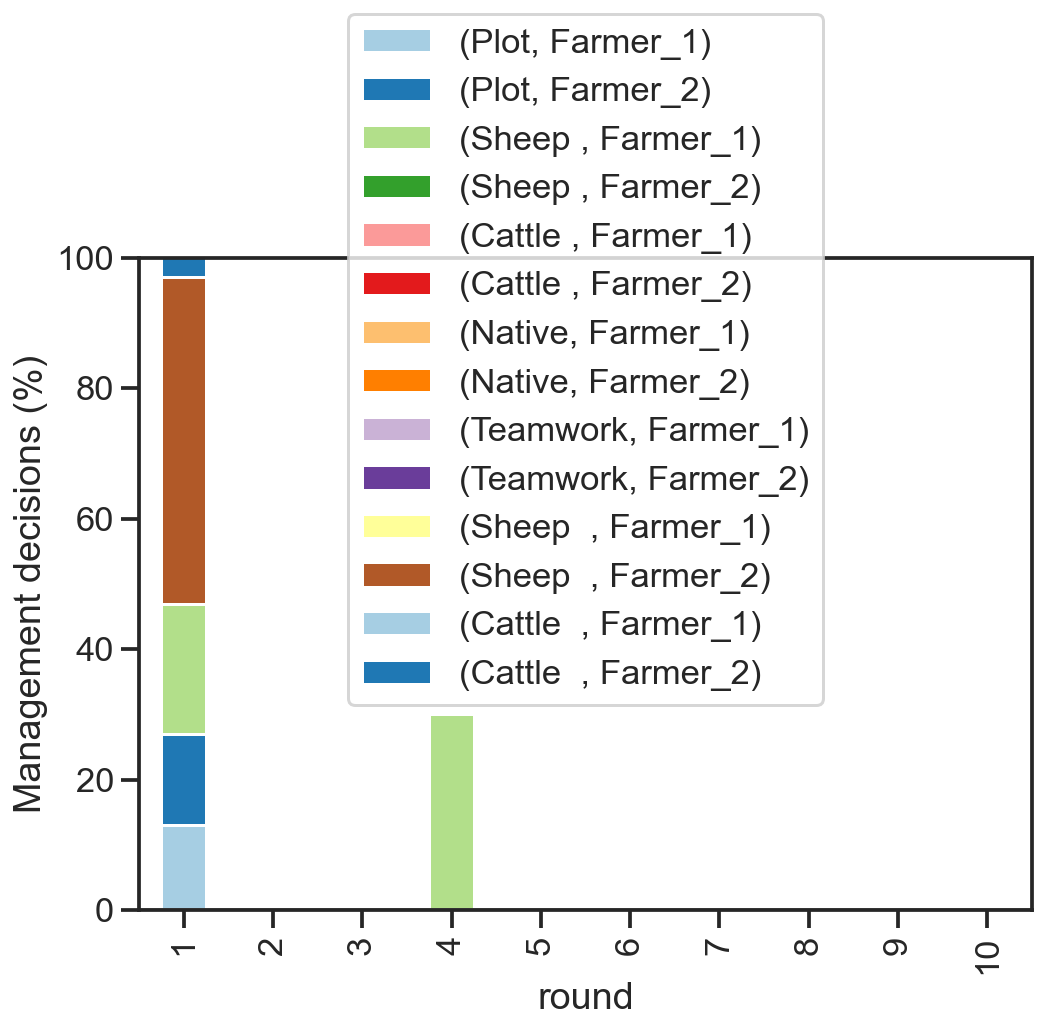

In [10]:
# https://stackoverflow.com/questions/4700614/how-to-put-the-legend-out-of-the-plot

# plot decisions
ax = df_final.plot(kind='bar', stacked=True, figsize=(10,6))

# Shrink current axis by 20% & put a legend to the right of the current axis
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.4))

# labels
ax.set_ylabel("Management decisions (%)")
ax.axhline(linestyle="-", color="grey")
ax.set_ylim(0, 100)
